Sentiment analysis using logistic regression

Import libraries:

In [67]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.stem import PorterStemmer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
reviews = []
threshold = 1e6 #1 million reviews
with open('../input/yelp-dataset/yelp_academic_dataset_review.json') as fl:
    for i, line in enumerate(fl):
        reviews.append(json.loads(line)) #use 'loads' since line is string
        if i + 1 >= threshold:
            break
df_reviews = pd.DataFrame(reviews)

# print the first five rows
df_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


Focus on *stars* and *text* only:

In [3]:
df_reviews = df_reviews[['text', 'stars']]
df_reviews.head()

,text,stars
0,"As someone who has worked with many museums, I...",2.0
1,I am actually horrified this place is still in...,1.0
2,I love Deagan's. I do. I really do. The atmosp...,5.0
3,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1.0
4,"Oh happy day, finally have a Canes near my cas...",4.0


In [ ]:
df_reviews.isna().mean()

No missing values

stars distribution:

In [ ]:
stars_count = df_reviews['stars'].value_counts()
stars_count = stars_count.sort_index()

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(stars_count.index, stars_count.values)
plt.title("Ratings Distribution",fontsize = 20)
plt.ylabel('Number of Reviews', fontsize = 12)
plt.xlabel('Number of Stars', fontsize = 12);

Treat 4,5 as positive sentiment and 1,2 as negative sentiment. Could treat 3 as neutral so it would be multi-class classification but for a simple binary classification we can take it out.

In [4]:
df_reviews=df_reviews[df_reviews.stars != 3]

pd.set_option('mode.chained_assignment', None)
df_reviews["labels"] = df_reviews["stars"].apply(lambda x: 1 if x < 3  else 0) # positive as 0 and negative as 1
df_reviews = df_reviews.drop("stars",axis=1)

df_reviews.head()

,text,labels
0,"As someone who has worked with many museums, I...",1
1,I am actually horrified this place is still in...,1
2,I love Deagan's. I do. I really do. The atmosp...,0
3,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
4,"Oh happy day, finally have a Canes near my cas...",0


Class distribution:

In [ ]:
label_count = df_reviews['labels'].value_counts()
label_count = label_count.sort_index()

fig = plt.figure(figsize=(6, 6))
ax = sns.barplot(label_count.index, label_count.values)
plt.title("Class Distribution",fontsize = 20)
plt.ylabel('Number of Reviews', fontsize = 12)
plt.xlabel('Sentiment', fontsize = 12);

In [ ]:
#baseline
print("{:.2f}".format(df_reviews[df_reviews.labels == 0].shape[0]/df_reviews.shape[0]))

train test split

In [5]:
train, test = train_test_split(df_reviews, test_size = 0.3, stratify = df_reviews['labels'], random_state = 42)

In [6]:
punct = set(string.punctuation)

In [7]:
def text_prep(text):
    #clean text
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    #remove non-letters and lower case
    text = re.sub('[^a-z\s]', '', text.lower())
    
    #remove punctuation        
    punc_removed = [char for char in text if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    return [word for word in punc_removed.split()]

binary feature representation, no stopwords removal or stemming, all unigrams

In [71]:
start_time = time.time()
cv= CountVectorizer(binary=True, analyzer = text_prep, min_df = 10, max_df = 0.95)
cv.fit_transform(train['text'].values)
train_feature_set=cv.transform(train['text'].values)
test_feature_set=cv.transform(test['text'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  5.44  mins


In [9]:
train_feature_set.shape[1]

40245

In [10]:
cv.vocabulary_['tasty']

35283

In [ ]:
list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(23451)]

In [11]:
y_train = train['labels'].values
y_test = test['labels'].values

In [72]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to train model and make predictions:  3.54  mins


In [13]:
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.955
F1:  0.914


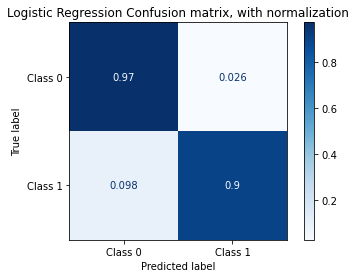

In [14]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

In [ ]:
feature_importance = lr.coef_[0][:10]
for i,v in enumerate(feature_importance):
    print('Feature: ', list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(i)], 'Score: ', v)

In [15]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)

Top words for the positive class (negative sentiment):

In [16]:
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['poisoning', 'slowest', 'worst', 'mediocre', 'deteriorated', 'abysmal', 'underwhelmed', 'downhill', 'rudest', 'saddest']


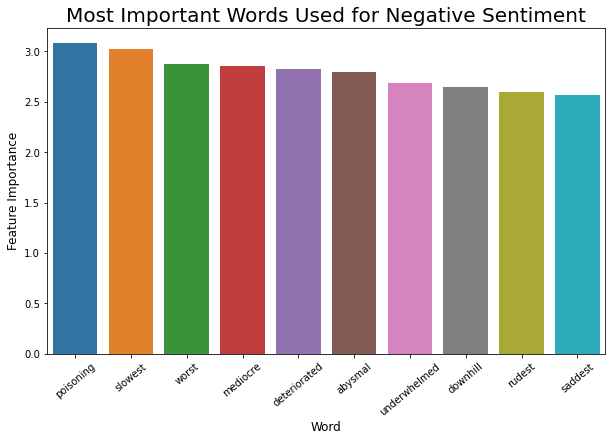

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]])
plt.title("Most Important Words Used for Negative Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

In [18]:
sub_poi = train.loc[train.text.str.contains('poisoning')]
round(sub_poi.labels.mean(),3)

0.904

Top words for the negative class (positive sentiment):

In [19]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['docking', 'exceeded', 'addicted', 'perfection', 'painless', 'deter', 'pleasantly', 'dreading', 'downside', 'delicious']


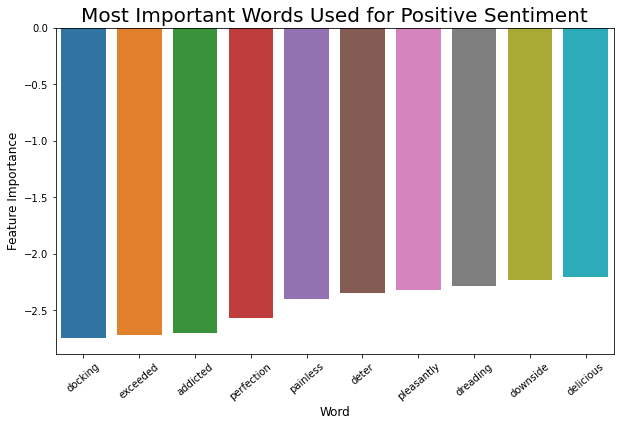

In [20]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]])
plt.title("Most Important Words Used for Positive Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

In [73]:
test_review = cv.transform(["I did not enjoy the food or the service"])
lr.predict_proba(test_review)

array([[0.50069323, 0.49930677]])

In [60]:
pred_proba_df = pd.DataFrame(lr.predict_proba(test_feature_set))
threshold_list = [0.3,0.4,0.45,0.5]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_f1 = round(metrics.f1_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('F1: {}'.format(test_f1))


******** For i = 0.3 ******
F1: 0.91

******** For i = 0.4 ******
F1: 0.915

******** For i = 0.45 ******
F1: 0.915

******** For i = 0.5 ******
F1: 0.914


Stopwords removal and stemming:

In [35]:
sw = set(stopwords.words("english"))
ps = PorterStemmer()

In [36]:
def text_prep_stop_stem(text):
    #clean text
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    #remove non-letters and lower case
    text = re.sub('[^a-z\s]', '', text.lower())
    
    #remove punctuation        
    punc_removed = [char for char in text if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    #stem and remove stop words
    return [ps.stem(word) for word in punc_removed.split() if not word in sw]
    #return [word for word in punc_removed.split() if not word in sw]

In [37]:
start_time = time.time()
cv= CountVectorizer(binary=True, analyzer = text_prep_stop_stem, min_df = 10, max_df = 0.95)
cv.fit_transform(train['text'].values)
train_feature_set=cv.transform(train['text'].values)
test_feature_set=cv.transform(test['text'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  60.04  mins


In [ ]:
train_feature_set.shape[1]

In [38]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Time takes to train model and make predictions:  2.01  mins
Accuracy:  0.949
F1:  0.902


Try undersampling/oversampling

In [74]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(train_feature_set,y_train)
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_under,y_under)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Time takes to train model and make predictions:  26.26  mins
Accuracy:  0.947
F1:  0.904


In [75]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train_feature_set,y_train)
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(X_over,y_over)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Time takes to train model and make predictions:  36.35  mins
Accuracy:  0.95
F1:  0.908


Trying TFIDF Vectorizer:

In [39]:
start_time = time.time()
tfidf_v=TfidfVectorizer(use_idf=True, analyzer = text_prep, min_df = 10, max_df = 0.95)
tfidf_v.fit_transform(train['text'].values)
train_feature_set=tfidf_v.transform(train['text'].values)
test_feature_set=tfidf_v.transform(test['text'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  5.53  mins


In [40]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Time takes to train model and make predictions:  0.52  mins
Accuracy:  0.958
F1:  0.919


Unigram and bigram:

In [61]:
start_time = time.time()
cv = CountVectorizer(binary=True, min_df = 10, max_df = 0.95, ngram_range=(1,2))
cv.fit_transform(train['text'].values)
train_feature_set=cv.transform(train['text'].values)
test_feature_set=cv.transform(test['text'].values)
print("Time takes to convert text input into feature vector: ", round((time.time() - start_time)/60, 2), " mins")

Time takes to convert text input into feature vector:  8.97  mins


In [42]:
train_feature_set.shape[1]

488683

In [ ]:
cv.vocabulary_

In [62]:
start_time = time.time()
lr = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Time takes to train model and make predictions: ", round((time.time() - start_time)/60, 2), " mins")
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Time takes to train model and make predictions:  5.68  mins
Accuracy:  0.969
F1:  0.942


In [ ]:
feature_importance = lr.coef_[0][:10]
for i,v in enumerate(feature_importance):
    print('Feature: ', list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(i)], 'Score: ', v)

In [63]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['two stars', 'worst', 'not worth', 'at best', 'mediocre', 'no thanks', 'disgusting', 'terrible', 'not recommend', 'meh']


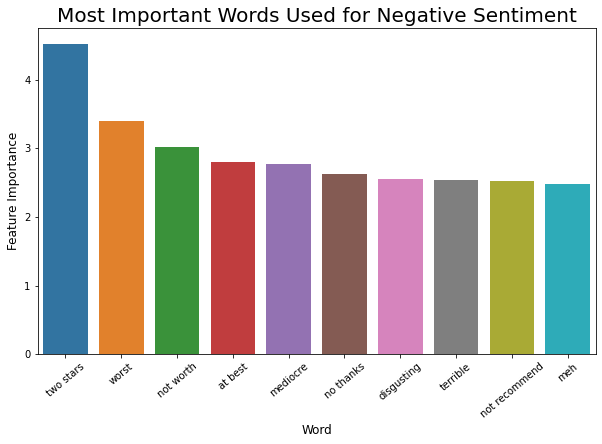

In [64]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_pos_w, feature_importance[sorted_idx[range(-1,-11, -1)]])
plt.title("Most Important Words Used for Negative Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

In [65]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['not disappointed', 'never disappointed', 'be disappointed', 'four stars', 'delicious', 'perfection', 'excellent', 'awesome', 'you won', 'amazing']


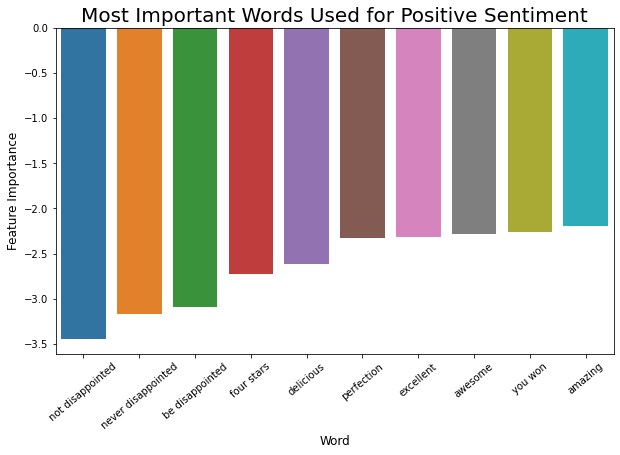

In [66]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_neg_w, feature_importance[sorted_idx[:10]])
plt.title("Most Important Words Used for Positive Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

In [70]:
lr.classes_ #negative class first, positive class next

array([0, 1])

In [69]:
test_review = cv.transform(["I did not enjoy the food or the service"])
lr.predict_proba(test_review)

array([[0.2678198, 0.7321802]])